# Livrable 2 - Traitement d'images

Groupe 2 :
- Brenda DJIGUEMDE
- Bruno DIAS
- Dany KHADHAR
- Romaric DEMBELE

INTRODUCTION

Le but est de traiter un ensemble de photographies afin de les rendre mieux traitables par les algorithmes de Machine Learning. Le traitement à réaliser est une opération de débruitage. Vous devrez produire un notebook Jupyter explicitant ces étapes de prétraitement, et leurs performances. Ces algorithmes s'appuieront sur les auto-encodeurs à convolution, et les appliqueront pour améliorer la qualité de l'image.

Cahier de charges du livrable :

- Le code de chargement du fichier.
- Le code du débruitage sur un sous-ensemble d'images bruitées. Le code doit être accompagné d'explications.
- Une étude de cas.

Imports de librairies

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Variables globales

In [2]:
BATCH_SIZE = 32  # Taille du batch
DATASET_PATH = './dataset_livrable_2' 

# Configuration de paramètres pour l'entraînement
EPOCHS = 50 # Nombre d'époques pour l'entraînement
STEPS_PER_EPOCH  = 100  # Nombre de batches d'entraînement par époque
VALIDATION_STEPS = 50  # Nombre de batches de validation par époque

## 1. Chargement des données

In [3]:
# Création d'un DataFrame contenant les chemins des images
image_paths = [os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_df = pd.DataFrame({'filename': image_paths})

# Configuration de l'ImageDataGenerator pour la normalisation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Création du générateur de données d'entraînement et de validation
train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode=None,  # Pas de labels car l'image est sa propre cible
    batch_size=BATCH_SIZE,
    subset='training',  # Défini pour utiliser la répartition de validation
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode=None,  # Pas de labels
    batch_size=BATCH_SIZE,
    subset='validation',  # Défini pour utiliser la répartition de validation
    shuffle=True
)

# Affichage des informations sur le générateur
for data_batch in train_generator:
    print('Batch shape:', data_batch.shape)
    break  # Affiche seulement le premier lot


Found 119 validated image filenames.
Found 29 validated image filenames.


Batch shape: (32, 224, 224, 3)


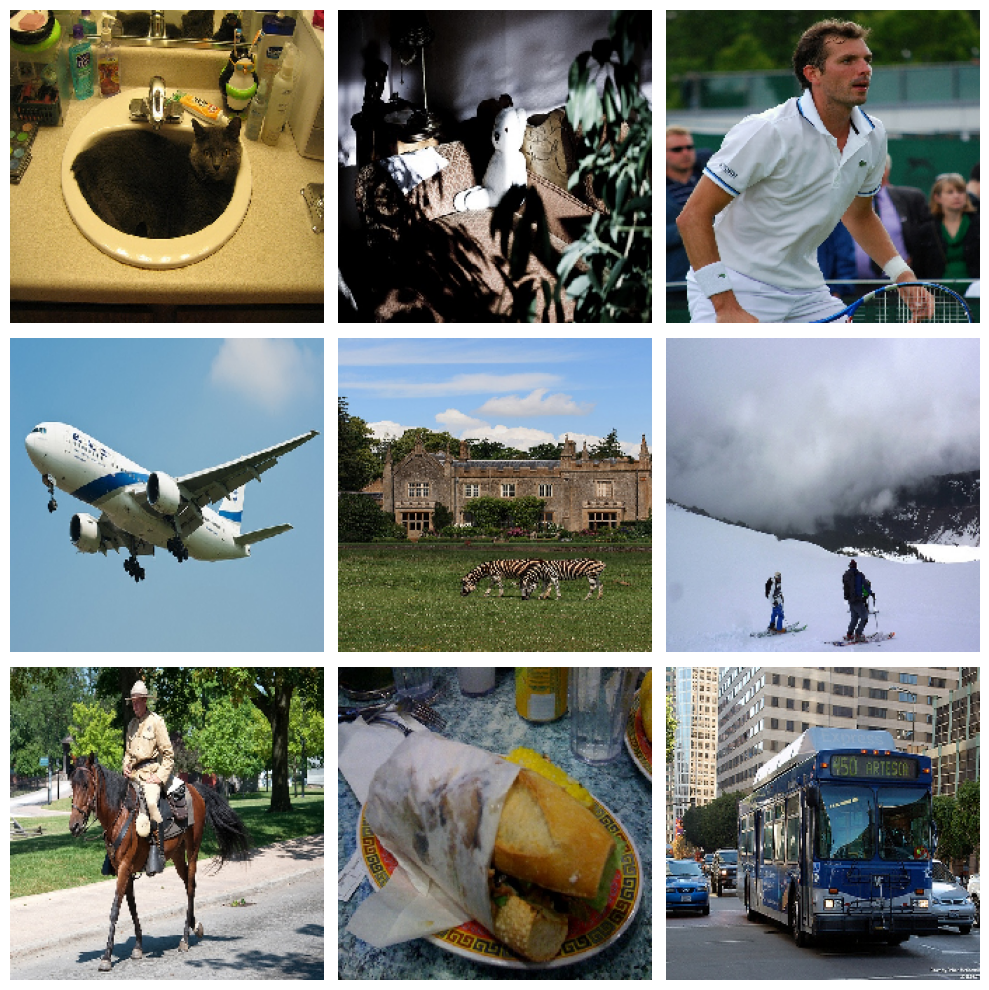

In [4]:
import matplotlib.pyplot as plt

def show_images(train_generator):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Crée un grid de 3x3 pour les images
    axes = axes.flatten()
    batch = next(iter(train_generator))  # Récupère un lot d'images du générateur
    for i, ax in enumerate(axes):
        if i < len(batch):  # Vérifie si l'index est inférieur au nombre d'images dans le lot
            ax.imshow(batch[i])  # Affiche l'image dans le subplot
            ax.axis('off')  # Désactive les axes
    plt.tight_layout()  # Ajuste la disposition
    plt.show()

# Appelez la fonction pour montrer les images
show_images(train_generator)


## 2. Création d'un jeu de données bruité

In [5]:
# Fonction pour ajouter du bruit gaussien aux images
def add_noise(img, noise_level=0.1):
    '''Ajoute un bruit gaussien aléatoire à une image.'''
    noise = np.random.normal(loc=0.0, scale=noise_level, size=img.shape)
    img_noisy = img + noise
    img_noisy = np.clip(img_noisy, 0, 1)  # Garantir que les valeurs restent dans [0, 1]
    return img_noisy

def noisy_generator(generator, noise_level=0.1):
    '''Generates pairs of noisy and original images.'''
    for batch in generator:
        original_batch = batch.copy()  # Copy the original images before adding noise
        noisy_batch = np.array([add_noise(image, noise_level) for image in original_batch])
        yield noisy_batch, original_batch  # Yield both the noisy and the original images


In [6]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: noisy_generator(train_generator, noise_level=0.1),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Noisy images
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)   # Original images
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: noisy_generator(validation_generator, noise_level=0.1),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Noisy images
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32)   # Original images
    )
)

# Example usage with TensorFlow training loop
for x, y in train_dataset.take(1):
    print('Batch shape:', x.numpy().shape)

Batch shape: (32, 224, 224, 3)


In [7]:
import matplotlib.pyplot as plt

def show_data_set_images(train_dataset):
    # Generate one batch from the dataset
    try:
        noisy_batch, original_batch = next(iter(train_dataset))
    except StopIteration:
        print("No more data available in the dataset.")
        return

    # Determine how many image pairs we can show
    num_images = len(noisy_batch)  # Get the number of images in the batch
    num_pairs_to_show = min(num_images, 9)  # Can show up to 9 pairs (since there are 18 subplots)

    # Set up the figure with a grid of 3 rows and 6 columns
    fig, axes = plt.subplots(3, 6, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(num_pairs_to_show):
        # Display the noisy image on the left
        ax_noisy = axes[2 * i]
        ax_noisy.imshow(noisy_batch[i])
        ax_noisy.axis('off')
        ax_noisy.set_title('Noisy Image')

        # Display the original image on the right
        ax_original = axes[2 * i + 1]
        ax_original.imshow(original_batch[i])
        ax_original.axis('off')
        ax_original.set_title('Original Image')

    # Hide any remaining unused axes
    for j in range(2 * num_pairs_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


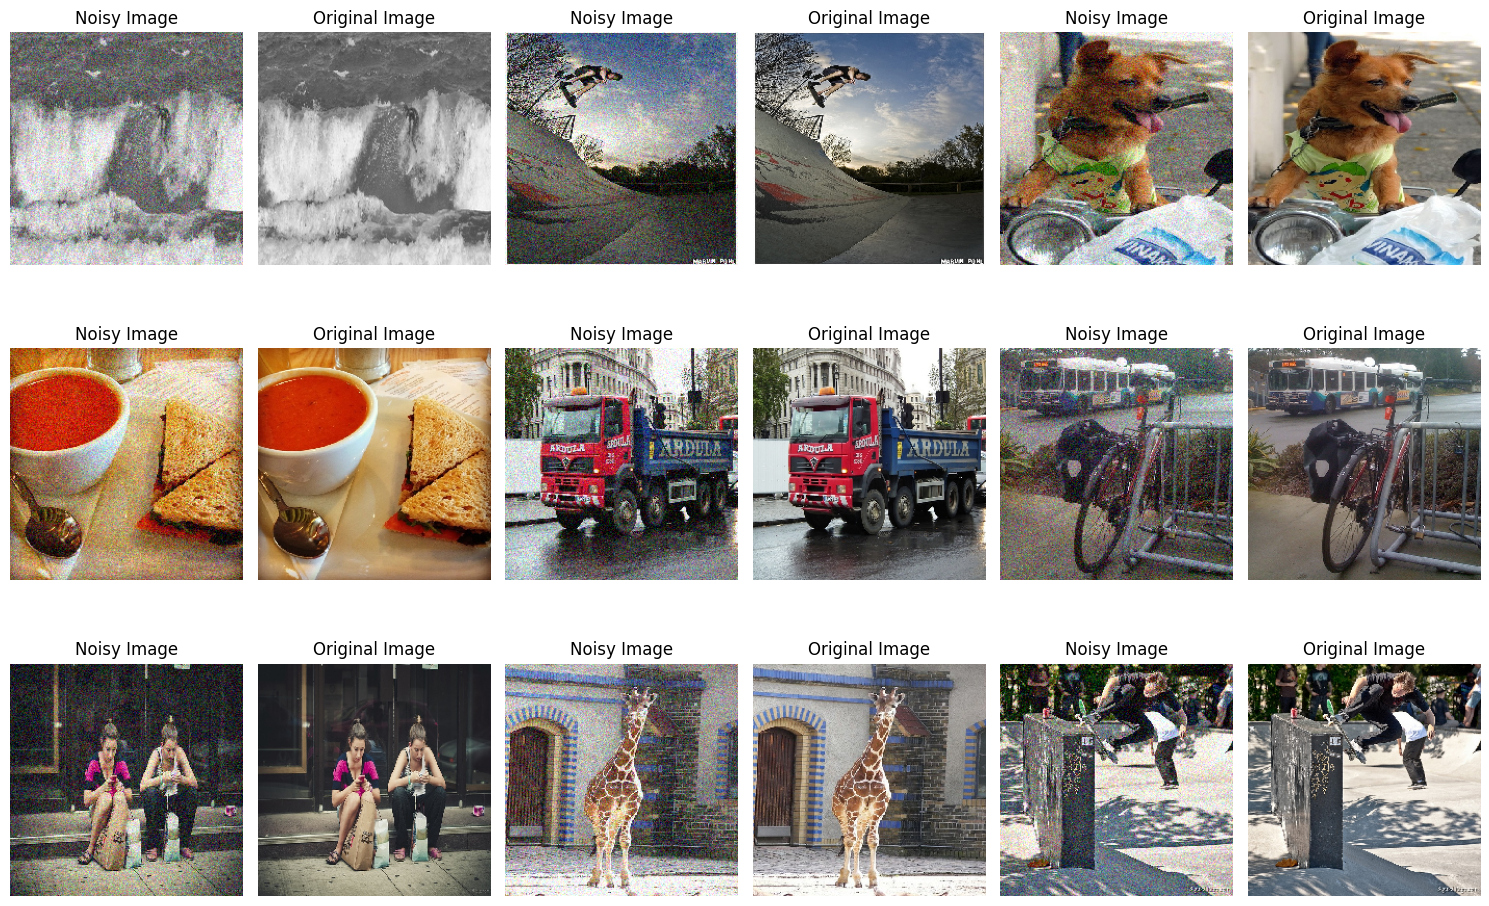

In [8]:
# Affichage des images bruitées
show_data_set_images(train_dataset)

## 3. Création du modèle auto-encodeur

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def build_autoencoder(input_shape=(224, 224, 3)):
    input_img = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Ensure padding is 'same'
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Create the autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return autoencoder

# Build and summarize the autoencoder model
autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,939 (54.45 KB)

 Trainable params: 13,939 (54.45 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Entraînement de l'autoencodeur
history = autoencoder.fit(
    x=train_dataset,  # Données d'entraînement
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,  # Données de validation
    validation_steps=VALIDATION_STEPS
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 655ms/step - accuracy: 0.3735 - loss: 0.0464 - val_accuracy: 0.6101 - val_loss: 0.0166
Epoch 2/50
 14/100 ━━━━━━━━━━━━━━━━━━━━ 41s 485ms/step - accuracy: 0.6360 - loss: 0.0173

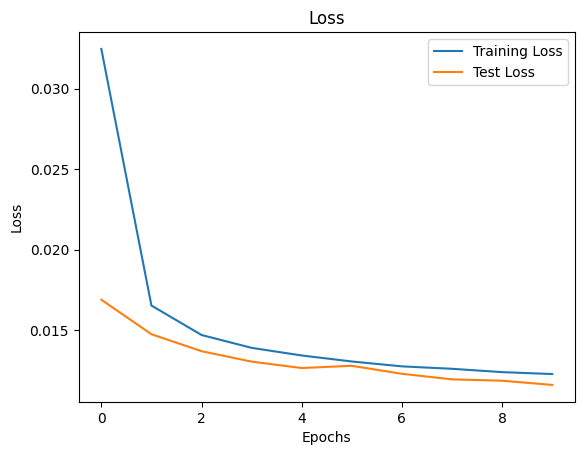

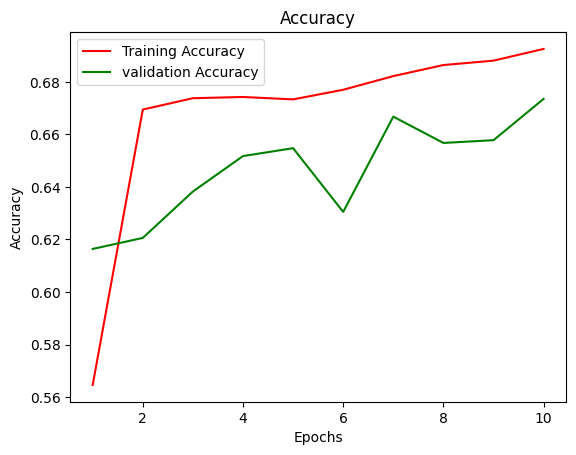

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Plotting the training accuracy
loss = history.history['loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



### Prédictions

In [ ]:
autoencoder_metrics = autoencoder.history.history
# Assuming you have a test dataset called test_data
predictions = autoencoder.predict(validation_dataset, batch_size=BATCH_SIZE)
print(autoencoder_metrics)


   2879/Unknown 976s 339ms/step

ResourceExhaustedError: Graph execution error:

Detected at node functional_1_1/up_sampling2d_2_1/Repeat_1/Tile defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 638, in run_forever

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1971, in _run_once

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 84, in _run

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 531, in process_one

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 775, in execute_request

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\Dias Bruno\AppData\Local\Temp\ipykernel_23448\3158791494.py", line 3, in <module>

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 515, in predict

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 213, in one_step_on_data_distributed

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 202, in one_step_on_data

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 94, in predict_step

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 814, in __call__

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 194, in call

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\function.py", line 151, in _run_through_graph

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 578, in call

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 814, in __call__

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\up_sampling2d.py", line 105, in call

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\up_sampling2d.py", line 156, in _resize_images

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\numpy.py", line 4473, in repeat

  File "c:\Users\Dias Bruno\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1531, in repeat

OOM when allocating tensor with shape[29,224,112,2,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node functional_1_1/up_sampling2d_2_1/Repeat_1/Tile}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_data_distributed_19370]

## 4. Sauvegarde de l'autoencodeur

In [ ]:
autoencoder.save('livrable_2_autoencoder.keras')  # Sauvegarde du modèle